In [1]:
%reset -f
import os
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import numpy as np
import scipy as sp
import numba as nb

from src.helper_functions import alert

###############
import ROOT as rt
from ROOT import TCanvas, TH1D, TH2D, TGraph, TGraphErrors, TLegend, TLatex, TLine, TBox, RDataFrame


rt.gStyle.SetOptStat(0)  # To display the mean and RMS:   SetOptStat("mr")
rt.gStyle.SetOptFit(1)
rt.gStyle.SetPadTopMargin(0.04)
rt.gStyle.SetPadBottomMargin(0.13)
rt.gStyle.SetPadLeftMargin(0.13)
rt.gStyle.SetPadRightMargin(0.04)
rt.gStyle.SetTitleFont(42, "XYZ")
rt.gStyle.SetTitleSize(0.06, "XYZ")
rt.gStyle.SetTitleXOffset(0.9)
# rt.gStyle.SetTitleYOffset(1.25)
rt.gStyle.SetTitleYOffset(1.0)
rt.gStyle.SetLabelFont(42, "XYZ")
rt.gStyle.SetLabelOffset(0.007, "XYZ")
rt.gStyle.SetLabelSize(0.05, "XYZ")
rt.gStyle.SetPadTickX(1)  # To get tick marks on the opposite side of the frame
rt.gStyle.SetPadTickY(1)
rt.gStyle.SetOptLogy(0)


rt.gStyle.SetPadTopMargin(0.04)
rt.gStyle.SetPadBottomMargin(0.14)
rt.gStyle.SetPadLeftMargin(0.14)
rt.gStyle.SetPadRightMargin(0.04)
rt.gStyle.SetTitleXOffset(1.0)
rt.gStyle.SetTitleYOffset(1.2)

gc = []
std_color_list = [1, 2, 4, 8, 6, 28, 43, 7, 25, 36, 30, 40, 42, 49, 46, 38, 32, 800, 600, 900, 870, 840]

# Be careful with memory management!
# RDataframes JIT compile every event loop (Define, Filter, etc). This will use a lot of RAM, I've allocated 64+ GB in just a few minutes
# Each thread you call will allocate an additional cache of memory-- so 8 threads can mean 8x more memory
# PyROOT (using 6.30/04) does not know how to release compiled RDataframe code

NTHREADS = 8
alert(f"Enabling implicit MT with {NTHREADS=}", c="r", b="w", s="bright")
rt.EnableImplicitMT(NTHREADS)

################

DATA_DIR = "/home/psimmerl/mds_analysis/data"

# YEAR = (2022, 2023)[0]
# fn_signal = f"{DATA_DIR}/raw/mc_{YEAR}.root"
# fn_data = f"{DATA_DIR}/raw/data_{YEAR}.root"

fn_signal_2022 = f"{DATA_DIR}/raw/mc_2022.root"
fn_signal_2023 = f"{DATA_DIR}/raw/mc_2023.root"
fn_data_2022 = f"{DATA_DIR}/raw/data_2022.root"
fn_data_2023 = f"{DATA_DIR}/raw/data_2023.root"

fn_signal_2022 = f"signal_2022.root"
fn_signal_2023 = f"signal_2023.root"
fn_data_2022 = f"data_2022.root"
fn_data_2023 = f"data_2023.root"


Welcome to JupyROOT 6.30/04
Enabling implicit MT with NTHREADS=8


In [2]:
MIN_CSC_TIME_WEIGHTED = -5
MAX_CSC_TIME_WEIGHTED = 12.5

MAX_CSC_JET_PT = 30
MAX_CSC_MUON_PT = 10

MAX_DT_JET_PT = 30
MAX_DT_MUON_PT = 10

MIN_DNN = 0.96

################

weights = {}
raw_rdfs = {}
rdfs = {
    # "signal" : RDataFrame("MuonSystem", fn_signal),
    # "data" : RDataFrame("MuonSystem", fn_data),
    "signal 2022" : RDataFrame("MuonSystem", fn_signal_2022),#"signal_2022.root"),
    "signal 2023" : RDataFrame("MuonSystem", fn_signal_2023),#"signal_2023.root"),
    "data 2022" : RDataFrame("MuonSystem", fn_data_2022),#"data_2022.root"),
    "data 2023" : RDataFrame("MuonSystem", fn_data_2023),#"data_2023.root"),
}

################
C, D = "cscRechitCluster", "dtRechitCluster"

csc_gllp_req = f"""{C}_match_gLLP
&& (abs({C}_match_gLLP_eta) < 3)
&& ({C}_match_gLLP_decay_r < 800)
&& (400 < abs({C}_match_gLLP_decay_z))
&& (abs({C}_match_gLLP_decay_z) < 1200)"""

dt_gllp_req = f"""{D}_match_gLLP
&& (200 < {D}_match_gLLP_decay_r)
&& ({D}_match_gLLP_decay_r < 800)
&& (abs({D}_match_gLLP_decay_z) < 700)"""

l1_plateau_req = f"""
auto me11 = (100 < {C}R) && ({C}R < 275) && ( 580 < abs({C}Z)) && (abs({C}Z) <  632) && (500 <= {C}Size);
auto me12 = (275 < {C}R) && ({C}R < 465) && ( 668 < abs({C}Z)) && (abs({C}Z) <  724) && (200 <= {C}Size);
auto me13 = (505 < {C}R) && ({C}R < 700) && ( 668 < abs({C}Z)) && (abs({C}Z) <  724) && (200 <= {C}Size);
auto me21 = (139 < {C}R) && ({C}R < 345) && ( 789 < abs({C}Z)) && (abs({C}Z) <  850) && (500 <= {C}Size);
auto me22 = (357 < {C}R) && ({C}R < 700) && ( 791 < abs({C}Z)) && (abs({C}Z) <  850) && (200 <= {C}Size);
auto me31 = (160 < {C}R) && ({C}R < 345) && ( 915 < abs({C}Z)) && (abs({C}Z) <  970) && (500 <= {C}Size);
auto me32 = (357 < {C}R) && ({C}R < 700) && ( 911 < abs({C}Z)) && (abs({C}Z) <  970) && (200 <= {C}Size);
auto me41 = (178 < {C}R) && ({C}R < 345) && (1002 < abs({C}Z)) && (abs({C}Z) < 1063) && (500 <= {C}Size);
auto me42 = (357 < {C}R) && ({C}R < 700) && (1002 < abs({C}Z)) && (abs({C}Z) < 1063) && (200 <= {C}Size);
return ( me11 || me12 || me13 || me21 || me22 || me31 || me32 || me41 || me42 );
"""

################
print(f"Looping through {len(rdfs)} RDFs and adding selection columns")
kpad = max([len(k) for k in rdfs.keys()])

for key, rdf in rdfs.items():
    count, weight = rdf.Count(), rdf.Sum("weight")
    count, weight = count.GetValue(), weight.GetValue()
    print(f"{key:>{kpad}}: N events = {count:>10,} (weight = {weight:>13,.2f})")
    # print(f"{key:>{kpad}}: N events = {count.GetValue():>10,} (weight = {weight.GetValue():>13,.2f})")
    weights[key] = weight

    col_names = list(rdf.GetColumnNames())
    if "pass_l1_hlt" not in col_names:
        rdf = rdf.Define(f"{C}R", f"ROOT::VecOps::sqrt( {C}X*{C}X +{C}Y*{C}Y )")
        rdf = rdf.Define(f"{D}R", f"ROOT::VecOps::sqrt( {D}X*{D}X +{D}Y*{D}Y )")
        rdf = rdf.Define(f"{C}NHitME1", f"{C}NRechitChamberPlus11 + {C}NRechitChamberMinus11 + {C}NRechitChamberPlus12 + {C}NRechitChamberMinus12")
        rdf = rdf.Define(f"{D}MB1", f"{D}NHitStation1")
        rdf = rdf.Define(f"{C}DNN", f"Take({C}DNN_bkgMC_plusBeamHalo, nCscRechitClusters)")

        # if "signal" in key:
        rdf = rdf.Define("pass_csc_gllp", csc_gllp_req)
        rdf = rdf.Define("pass_dt_gllp", dt_gllp_req)

        rdf = rdf.Define("pass_hlt_csccsc", "HLTDecision[566]")
        rdf = rdf.Define("pass_hlt_cscdt", "HLTDecision[569]")

        rdf = rdf.Define("pass_csc_time", f"({MIN_CSC_TIME_WEIGHTED} < {C}TimeWeighted) && ({C}TimeWeighted < {MAX_CSC_TIME_WEIGHTED})")
        rdf = rdf.Define("pass_csc_tspread", f"{C}TimeSpreadWeightedAll < 20")
        rdf = rdf.Define("pass_csc_l1_pl", l1_plateau_req)
        rdf = rdf.Define("pass_csc_me1", f"{C}NHitME1 == 0")
        rdf = rdf.Define("pass_csc_jet", f"{C}JetVetoPt < {MAX_CSC_JET_PT}")
        rdf = rdf.Define("pass_csc_muon", f"!( ({C}MuonVetoGlobal>0) && ({C}MuonVetoPt>{MAX_CSC_MUON_PT}) )")

        rdf = rdf.Define("pass_dt_time", f"({D}_match_RPChits_dPhi0p5 > 0) && ({D}_match_RPCBx_dPhi0p5 == 0)")
        rdf = rdf.Define("pass_dt_mb1", f"{D}NHitStation1 == 0")
        rdf = rdf.Define("pass_dt_jet", f"{D}JetVetoPt < {MAX_DT_JET_PT}")
        rdf = rdf.Define("pass_dt_muon", f"!( ({D}MuonVetoLooseId>0) && ({D}MuonVetoPt>{MAX_DT_MUON_PT}) )")

        rdf = rdf.Define("pass_dnn", f"{C}DNN > {MIN_DNN}")

        rdf = rdf.Define("pass_exactly_2", "( (nCscRechitClusters == 2) && (nDtRechitClusters == 0) ) || ( (nCscRechitClusters == 1) && (nDtRechitClusters == 1) )")
        # rdf = rdf.Define("pass_exactly_2", "( pass_hlt_csccsc && (nCscRechitClusters == 2) && (nDtRechitClusters == 0) ) || ( pass_hlt_cscdt && (nCscRechitClusters == 1) && (nDtRechitClusters == 1) )")
        # rdf = rdf.Define("pass_l1", "ROOT::VecOps::Sum(pass_csc_me1 && pass_csc_l1_pl) > 0")
        # rdf = rdf.Define("pass_l1_hlt", "pass_l1 && ( pass_hlt_csccsc || (pass_hlt_cscdt && (ROOT::VecOps::Sum(pass_dt_mb1)>0)) )")
        rdf = rdf.Define("pass_l1", "ROOT::VecOps::Sum(pass_csc_time && pass_csc_me1 && pass_csc_l1_pl) > 0")
        rdf = rdf.Define("pass_l1_hlt", "pass_l1 && ( pass_hlt_csccsc || (pass_hlt_cscdt && (ROOT::VecOps::Sum(pass_dt_time && pass_dt_mb1)>0)) )")

    raw_rdfs[key] = rdf

    # Apply trigger level selections
    rdf = rdf.Filter("pass_l1_hlt")

    # Snapshot for speed-up later
    col_names = list(rdf.GetColumnNames())
    if "HLTDecision" in col_names:
        col_names.remove("HLTDecision")
    rdf = rdf.Snapshot("MuonSystem", key.replace(" ","_")+".root", col_names)

    count, weight = rdf.Count(), rdf.Sum("weight")
    count, weight = count.GetValue(), weight.GetValue()
    print(f"{'':>{kpad}}> N events = {count:>10,} (weight = {weight:>13,.2f})")
    # print(f"{'':>{kpad}}> N events = {count.GetValue():>10,} (weight = {weight.GetValue():>13,.2f})")

    rdfs[key] = rdf



Looping through 4 RDFs and adding selection columns
signal 2022: N events =  1,851,400 (weight = 42,883,742.59)
           > N events =     56,018 (weight =  1,297,628.92)
signal 2023: N events =  1,000,000 (weight = 23,162,831.44)
           > N events =     29,883 (weight =    692,224.73)
  data 2022: N events = 14,887,673 (weight = 14,887,673.00)
           > N events =  7,410,045 (weight =  7,410,045.00)
  data 2023: N events = 18,693,980 (weight = 18,693,980.00)
           > N events =  9,094,648 (weight =  9,094,648.00)


In [238]:
def histo1D(var, form, evt_sel="", csc_sel="", dt_sel="", logx=False, logy=False, normalized=False):
    nrows, ncols = 1, 1
    canvas, npads = TCanvas("","",800*ncols,800*nrows), nrows*ncols
    canvas.Divide(ncols, nrows)

    latex = TLatex()
    latex.SetTextColor(rt.kBlack)
    latex.SetTextAlign(33)
    latex.SetTextSize(0.03)
    latex.SetTextFont(42)

    # legend = TLegend(0.72, 0.70, 0.96, 0.94)
    legend = TLegend(0.52, 0.50, 0.96, 0.94)
    # legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
    legend.SetFillColorAlpha(rt.kWhite, 0.6)#0.2)
    legend.SetBorderSize(0)
    legend.SetTextSize(0.04)
    legend.SetMargin(0.15)

    ####
    if "pass_l1_hlt" in evt_sel:
        sel_rdfs = {key : (rdf.Filter(evt_sel) if evt_sel else rdf) for key, rdf in rdfs.items()}
    else:
        sel_rdfs = {key : (rdf if evt_sel else rdf) for key, rdf in raw_rdfs.items()}

    ####
    hists = []
    ymin, ymax = 1e9 if logy else 0, 0
    for irdf, (key, rdf) in enumerate(sel_rdfs.items()):
        _var = var
        if csc_sel and "csc" in var[:3]:
            _var = f"{var}[{csc_sel}]"
        elif dt_sel and "dt" in var[:2]:
            _var = f"{var}[{dt_sel}]"

        h = rdf.Define("var",_var).Histo1D(form, "var", "weight")
        h.SetName(key)
        h.Scale(1/weights[key])
        h.SetLineColor(std_color_list[irdf])
        h.SetLineWidth(3)
        ymin, ymax = min(ymin, h.GetMinimum(0)), max(ymax, h.GetMaximum())
        hists.append(h)

    if logy:
        ymin, ymax = ymin/3, ymax*3
    elif ymin != 0:
        ymin, ymax = ymin - (ymax-ymin)/20, ymax + (ymax-ymin)/20

    for ih, h in enumerate(hists):
        canvas.cd( (ih%npads) + 1 ).SetGrid()
        canvas.cd( (ih%npads) + 1 ).SetLogx(logx)
        canvas.cd( (ih%npads) + 1 ).SetLogy(logy)

        h = h.GetValue()
        legend.AddEntry(h, h.GetName(), 'L')
        h.SetMinimum(ymin)
        h.SetMaximum(ymax)
        if normalized:
            h.DrawNormalized("same hist")
        else:
            h.Draw("same hist")

    sel = ", ".join([x for x in [
        f"EVT: {evt_sel}" if evt_sel else "",
        f"CSC: {csc_sel}" if csc_sel else "",
        f"DT: {dt_sel}" if dt_sel else "",
    ] if x])

    if sel:
        latex.DrawLatexNDC(1, 1, sel)
    else:
        latex.DrawLatexNDC(1, 1, "no selections")

    legend.Draw()
    canvas.Draw()
    gc.extend([canvas, legend, latex, *hists])

    return hists




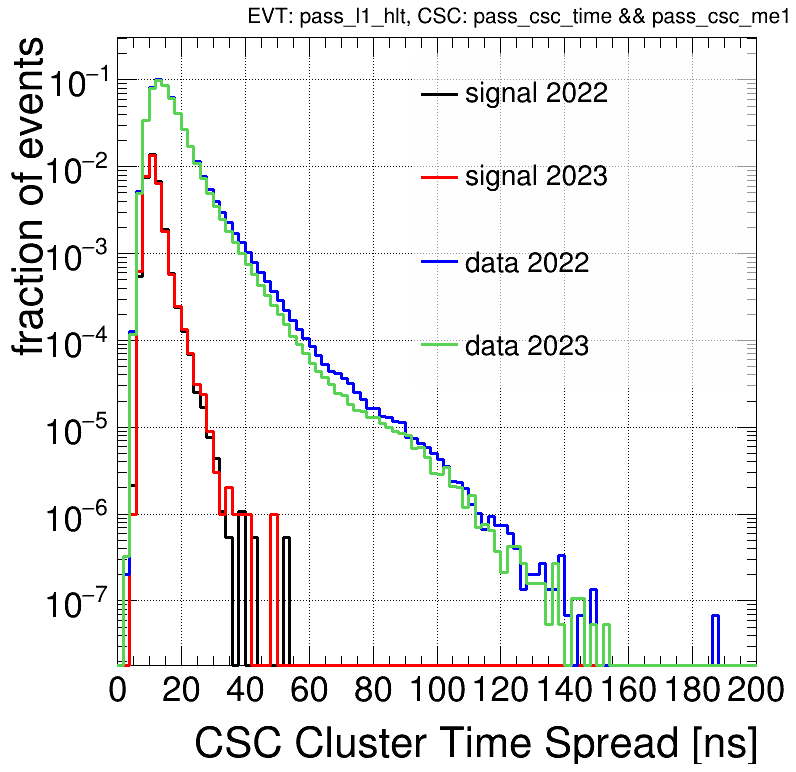

In [239]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_time"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"



####
# var = f"{C}TimeSpread"
var = f"{C}TimeSpreadWeightedAll"
form = ("", ";CSC Cluster Time Spread [ns];fraction of events", 100, 0, 200)
logx, logy = False, True

hists = histo1D(var, form, evt_sel, csc_sel, dt_sel, logx, logy)


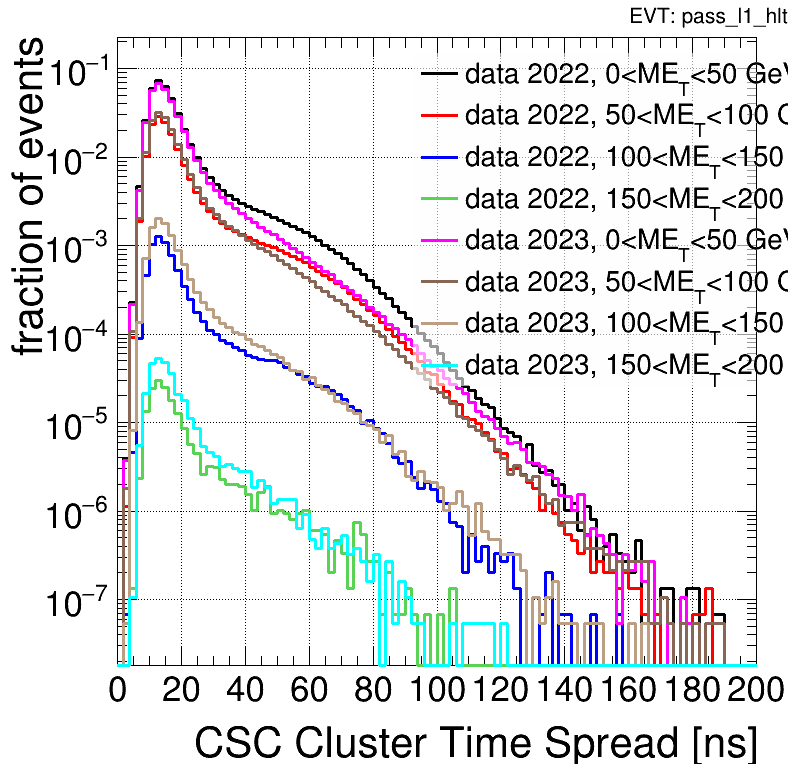

In [241]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_l1_pl"
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"

_raw_rdfs = raw_rdfs
_rdfs = rdfs


raw_rdfs = {
    "data 2022, 0<ME_{T}<50 GeV" : _raw_rdfs["data 2022"].Filter("(0 < met) && (met < 50)"),
    "data 2022, 50<ME_{T}<100 GeV" : _raw_rdfs["data 2022"].Filter("(50 < met) && (met < 100)"),
    "data 2022, 100<ME_{T}<150 GeV" : _raw_rdfs["data 2022"].Filter("(100 < met) && (met < 150)"),
    "data 2022, 150<ME_{T}<200 GeV" : _raw_rdfs["data 2022"].Filter("(150 < met) && (met < 200)"),
    "data 2023, 0<ME_{T}<50 GeV" : _raw_rdfs["data 2023"].Filter("(0 < met) && (met < 50)"),
    "data 2023, 50<ME_{T}<100 GeV" : _raw_rdfs["data 2023"].Filter("(50 < met) && (met < 100)"),
    "data 2023, 100<ME_{T}<150 GeV" : _raw_rdfs["data 2023"].Filter("(100 < met) && (met < 150)"),
    "data 2023, 150<ME_{T}<200 GeV" : _raw_rdfs["data 2023"].Filter("(150 < met) && (met < 200)"),
}
rdfs = {
    "data 2022, 0<ME_{T}<50 GeV" : _rdfs["data 2022"].Filter("(0 < met) && (met < 50)"),
    "data 2022, 50<ME_{T}<100 GeV" : _rdfs["data 2022"].Filter("(50 < met) && (met < 100)"),
    "data 2022, 100<ME_{T}<150 GeV" : _rdfs["data 2022"].Filter("(100 < met) && (met < 150)"),
    "data 2022, 150<ME_{T}<200 GeV" : _rdfs["data 2022"].Filter("(150 < met) && (met < 200)"),
    "data 2023, 0<ME_{T}<50 GeV" : _rdfs["data 2023"].Filter("(0 < met) && (met < 50)"),
    "data 2023, 50<ME_{T}<100 GeV" : _rdfs["data 2023"].Filter("(50 < met) && (met < 100)"),
    "data 2023, 100<ME_{T}<150 GeV" : _rdfs["data 2023"].Filter("(100 < met) && (met < 150)"),
    "data 2023, 150<ME_{T}<200 GeV" : _rdfs["data 2023"].Filter("(150 < met) && (met < 200)"),
}
for key in rdfs.keys():
    if key not in weights:
        weights[key] = weights[key.split(",")[0]]


# var = f"{C}TimeSpread"
var = f"{C}TimeSpreadWeightedAll"
form = ("", ";CSC Cluster Time Spread [ns];fraction of events", 100, 0, 200)
logx, logy = False, True

try:
    hists = histo1D(var, form, evt_sel, csc_sel, dt_sel, logx, logy, normalized=False)
except Exception as e:
    print(e)

raw_rdfs = _raw_rdfs
rdfs = _rdfs

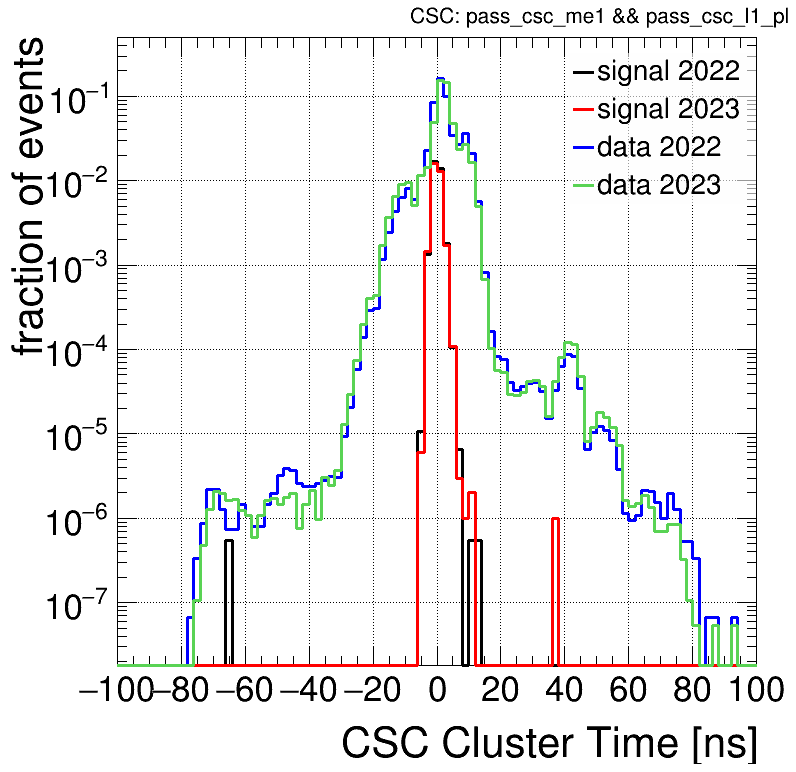

In [212]:
evt_sel = ""
# evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_l1_pl"
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
var = f"{C}TimeWeighted"
form = ("", ";CSC Cluster Time [ns];fraction of events", 50, -20, 20)
form = ("", ";CSC Cluster Time [ns];fraction of events", 100, -20, 20)
form = ("", ";CSC Cluster Time [ns];fraction of events", 100, -100, 100)
logx, logy= False, True

hists = histo1D(var, form, evt_sel, csc_sel, dt_sel, logx, logy)

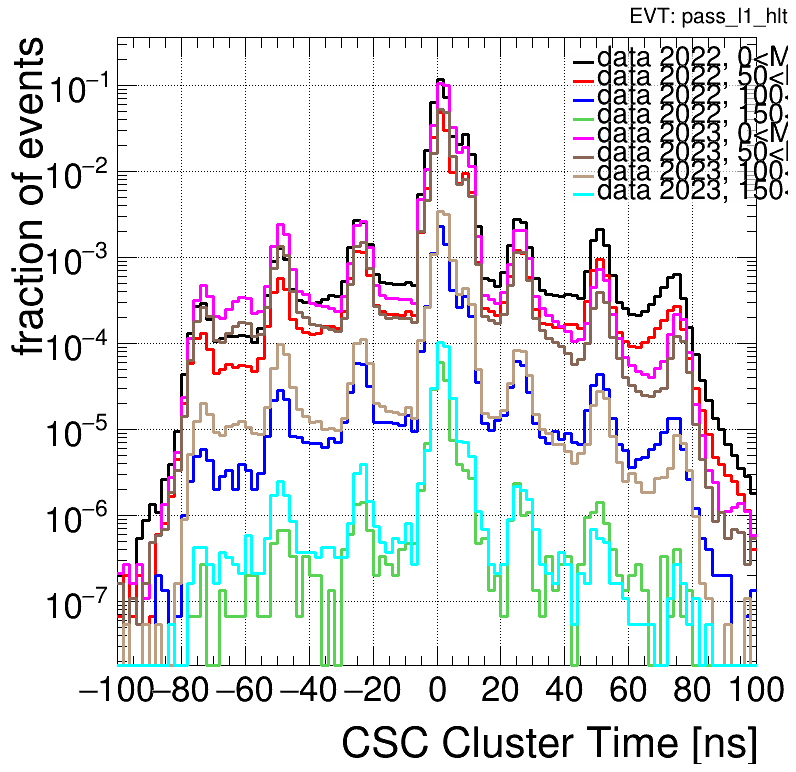

In [64]:
def histo2D(xvar, yvar, form, evt_sel="", csc_sel="", dt_sel="", logx=False, logy=False, logz=False, **kwargs):
    draw_opts = "col" if "draw_opts" not in kwargs else kwargs["draw_opts"]

    ncols = [x for x in range(1, int(len(rdfs)**0.5)+1) if len(rdfs)%x==0 ][-1]
    nrows = int(len(rdfs)/ncols)
    print(f"{len(rdfs)=} =? {nrows=} * {ncols=}")
    assert nrows * ncols >= len(rdfs)

    canvas, npads = TCanvas("","",800*ncols,800*nrows), nrows*ncols
    canvas.Divide(ncols, nrows)

    latex = TLatex()
    latex.SetTextColor(rt.kBlack)
    latex.SetTextAlign(33)
    latex.SetTextSize(0.06)
    latex.SetTextFont(42)

    # legend = TLegend(0.80, 0.64, 0.96, 0.94)
    # legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
    # legend.SetBorderSize(0)
    # legend.SetTextSize(0.04)
    # legend.SetMargin(0.15)

    ####
    if "pass_l1_hlt" in evt_sel:
        sel_rdfs = {key : (rdf.Filter(evt_sel) if evt_sel else rdf) for key, rdf in rdfs.items()}
    else:
        sel_rdfs = {key : (rdf if evt_sel else rdf) for key, rdf in raw_rdfs.items()}

    ####
    hists = []
    zmin, zmax = 1e9 if logz else 0, 0
    for irdf, (key, rdf) in enumerate(sel_rdfs.items()):
        _xvar = xvar
        if csc_sel and "csc" in xvar[:3]:
            _xvar = f"{xvar}[{csc_sel}]"
        elif dt_sel and "dt" in xvar[:2]:
            _xvar = f"{xvar}[{dt_sel}]"

        _yvar = yvar
        if csc_sel and "csc" in yvar[:3]:
            _yvar = f"{yvar}[{csc_sel}]"
        elif dt_sel and "dt" in yvar[:2]:
            _yvar = f"{yvar}[{dt_sel}]"

        h = rdf.Define("xvar",_xvar).Define("yvar",_yvar).Histo2D(form, "xvar", "yvar", "weight")
        h.SetName(key)
        h.Scale(1/weights[key])
        h.SetLineColor(std_color_list[irdf])
        h.SetLineWidth(3)
        zmin, zmax = min(zmin, h.GetMinimum(0)), max(zmax, h.GetMaximum())
        hists.append(h)

    # if logz:
    #     zmin, zmax = zmin, zmax
    # elif zmin != 0:
    #     zmin, zmax = zmin - (zmax-zmin)/20, zmax + (zmax-zmin)/20

    sel_text = ", ".join([x for x in [
        f"EVT: {evt_sel}" if evt_sel else "",
        f"CSC: {csc_sel}" if csc_sel else "",
        f"DT: {dt_sel}" if dt_sel else "",
    ] if x])
    sel_text = sel_text if sel_text else "no selections"

    for ih, h in enumerate(hists):
        canvas.cd( (ih%npads) + 1 ).SetGrid()
        canvas.cd( (ih%npads) + 1 ).SetLogx(logx)
        canvas.cd( (ih%npads) + 1 ).SetLogy(logy)
        canvas.cd( (ih%npads) + 1 ).SetLogz(logz)

        h = h.GetValue()
        # legend.AddEntry(h, h.GetName(), 'L')
        h.SetMinimum(zmin)
        h.SetMaximum(zmax)
        h.Draw(draw_opts)

        latex.SetTextSize(0.06)
        latex.SetTextAlign(33)
        latex.SetTextColor(h.GetLineColor())
        latex.DrawLatexNDC(0.96-0.01, 0.96-0.01, h.GetName())

        latex.SetTextSize(0.03)
        latex.SetTextAlign(33)
        latex.SetTextColor(rt.kBlack)
        latex.DrawLatexNDC(1, 1, sel_text)

    # legend.Draw()
    canvas.Draw()
    # gc.extend([canvas, legend, latex, *hists])
    gc.extend([canvas, latex, *hists])

    return hists



len(rdfs)=4 =? nrows=2 * ncols=2


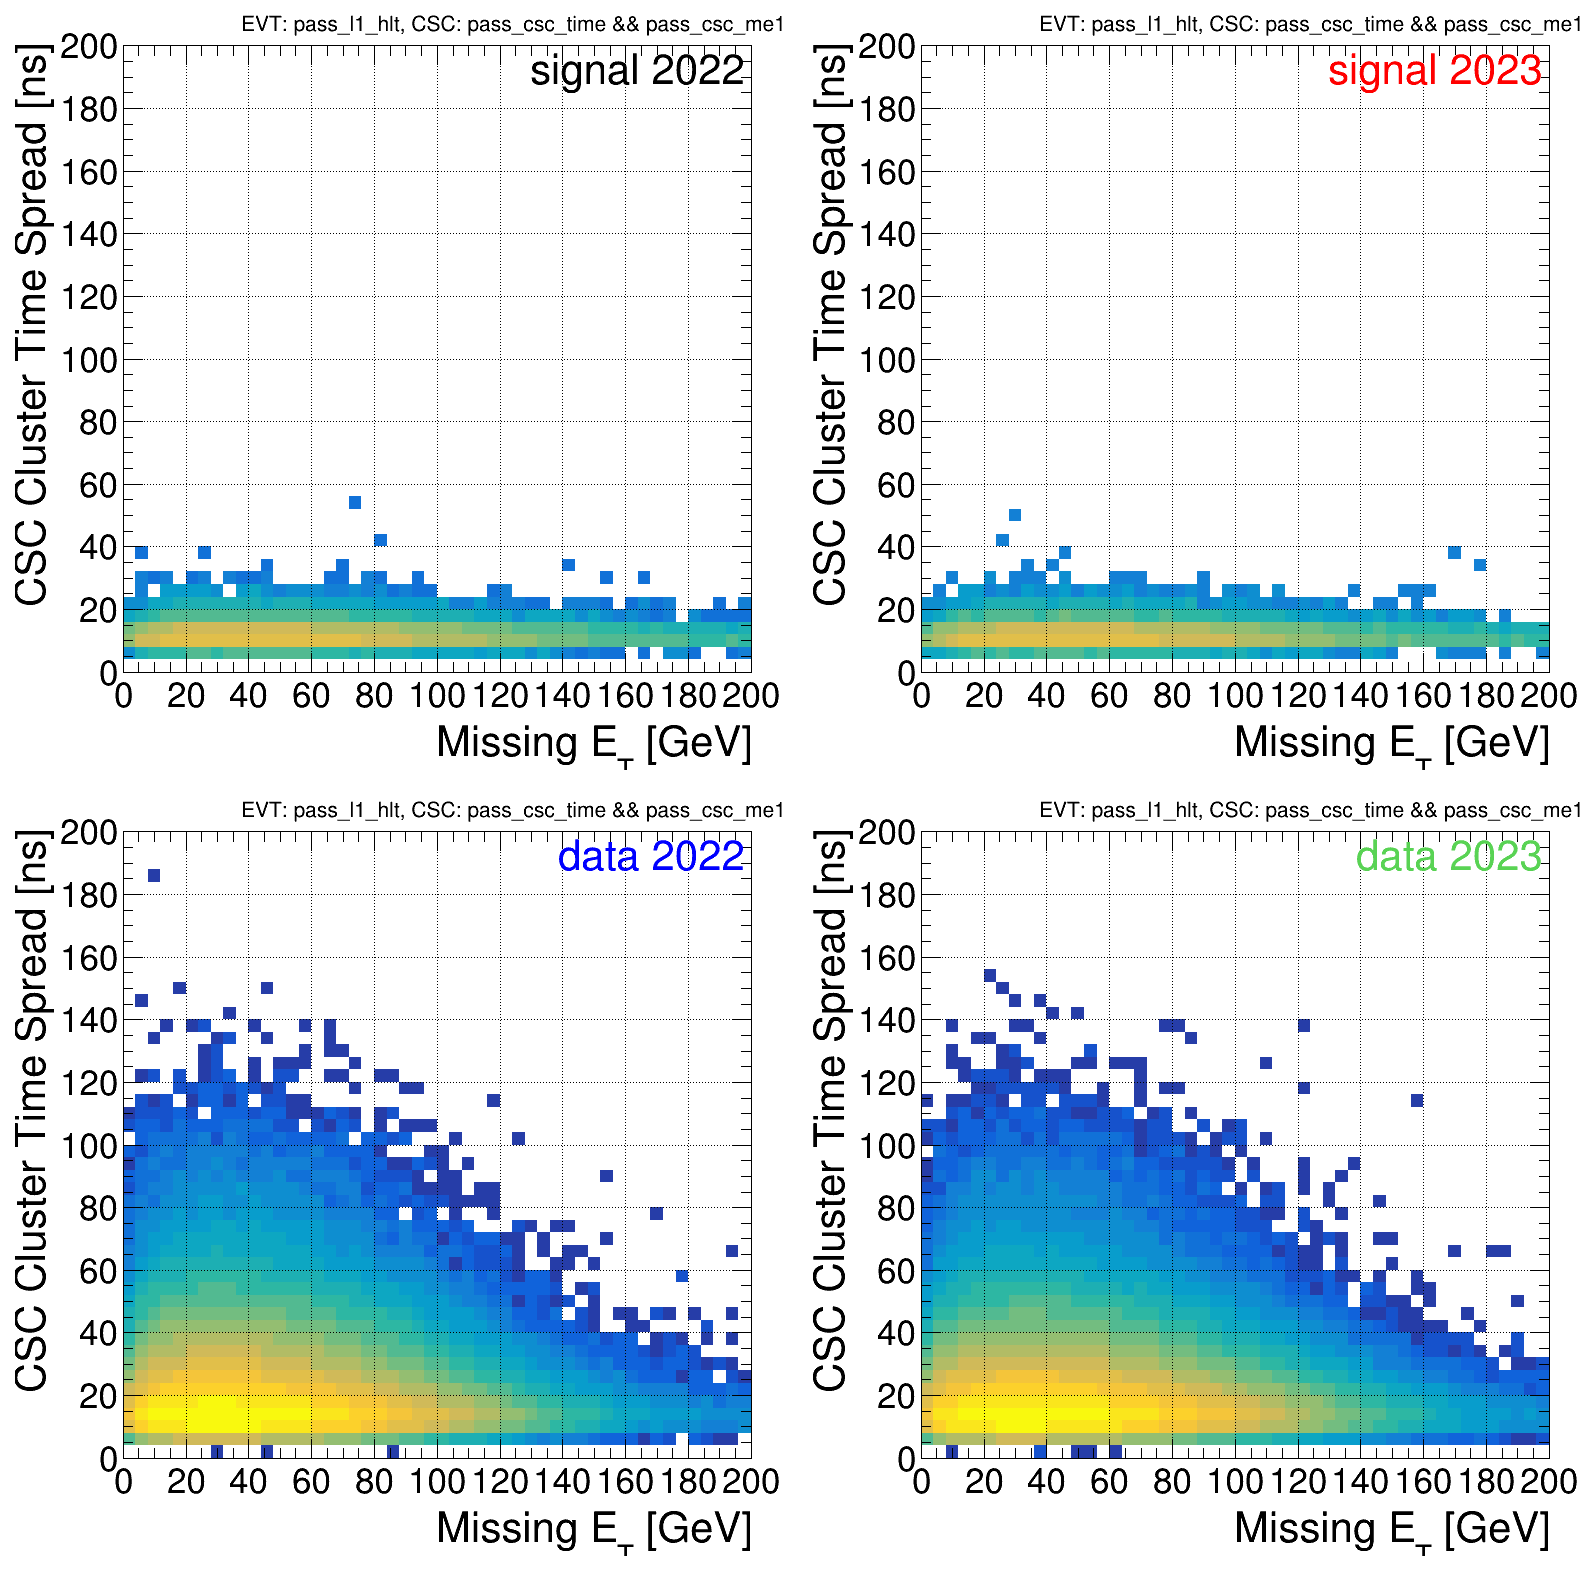

In [120]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_time"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = "met", f"{C}TimeSpreadWeightedAll"
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 200)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)#, draw_opts="cont1")

# XY Spread

len(rdfs)=4 =? nrows=2 * ncols=2


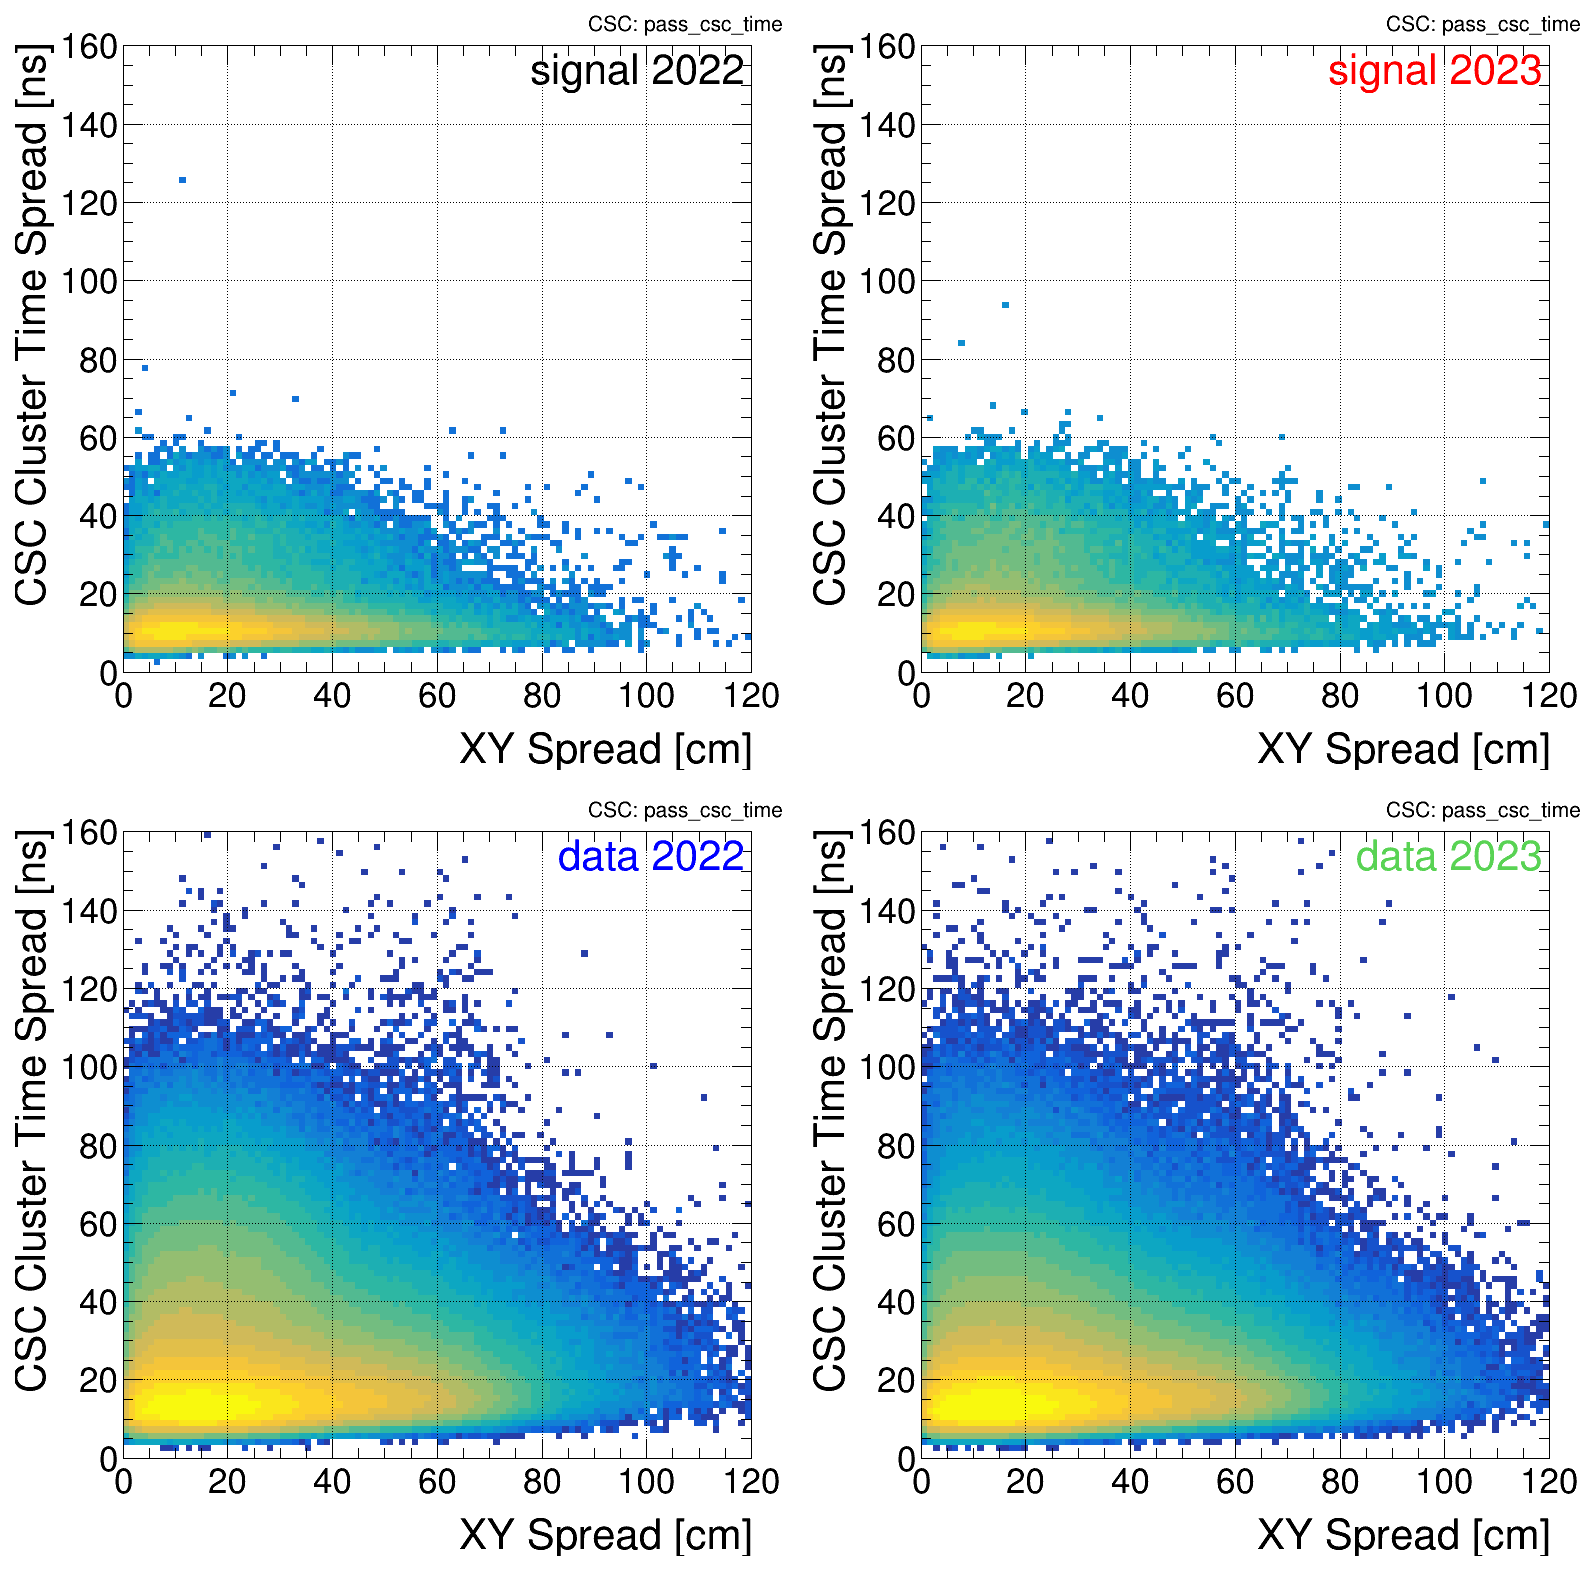

In [163]:
evt_sel = ""
# evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}XYSpread", f"met"
form = ("", ";XY Spread [cm];Missing E_{T} [GeV];fraction of events", 50, 0, 100, 50, 0, 200)
logx, logy, logz = False, False, True

xvar, yvar = f"met", f"{C}TimeSpreadWeightedAll"
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 200)
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 100)
logx, logy, logz = False, False, True

xvar, yvar = f"{C}XYSpread", f"{C}TimeSpreadWeightedAll"
form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 100, 50, 0, 200)
form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 120, 100, 0, 160)
# form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 120, 100, 0, 20)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


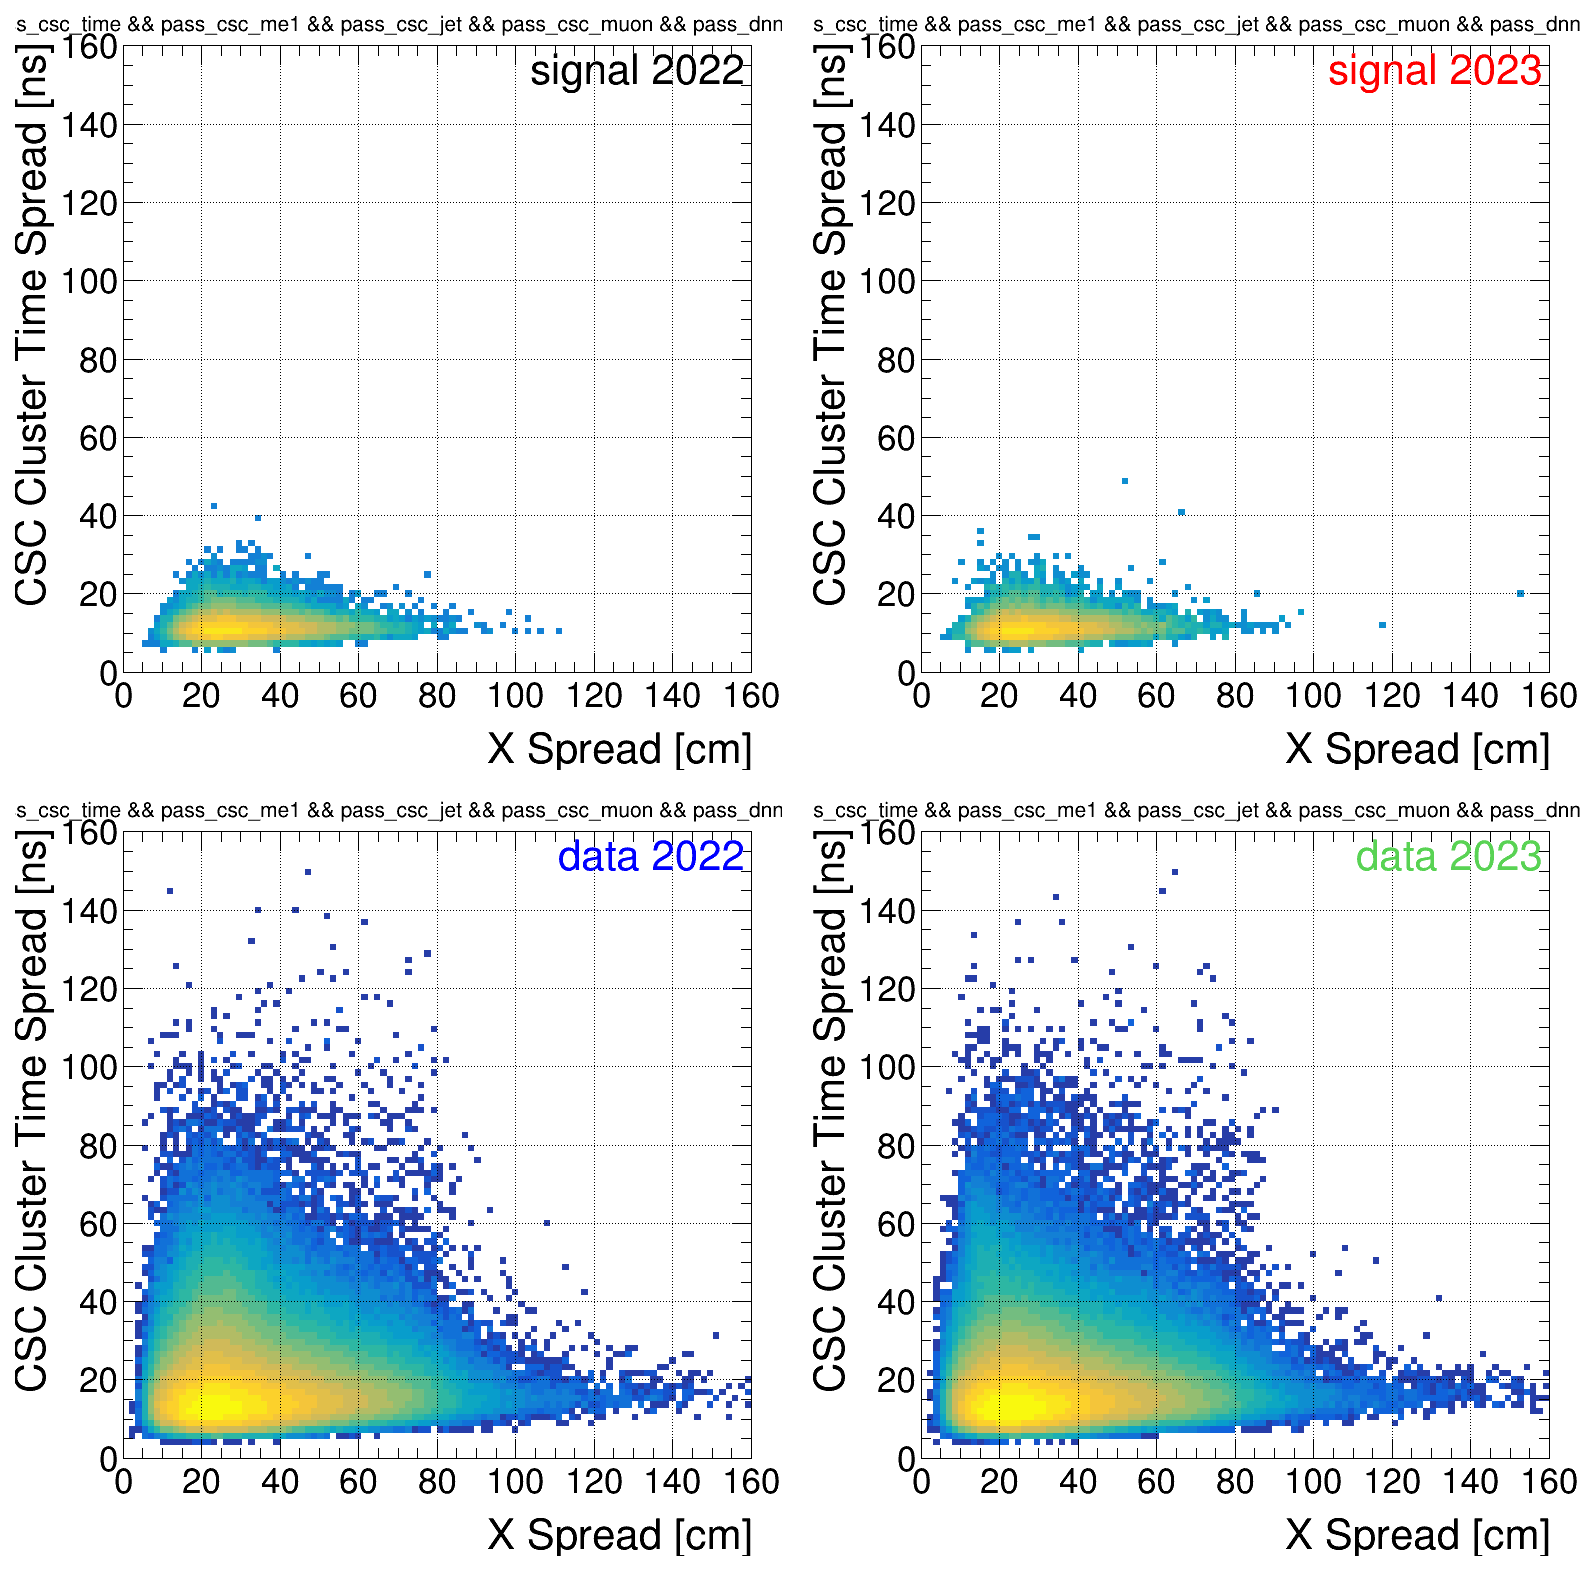

In [151]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}XSpread", f"met"
form = ("", ";X Spread [cm];Missing E_{T} [GeV];fraction of events", 50, 0, 100, 50, 0, 200)
logx, logy, logz = False, False, True

xvar, yvar = f"met", f"{C}TimeSpreadWeightedAll"
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 200)
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 100)
logx, logy, logz = False, False, True

xvar, yvar = f"{C}XSpread", f"{C}TimeSpreadWeightedAll"
form = ("", ";X Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 100, 50, 0, 200)
form = ("", ";X Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 160, 100, 0, 160)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


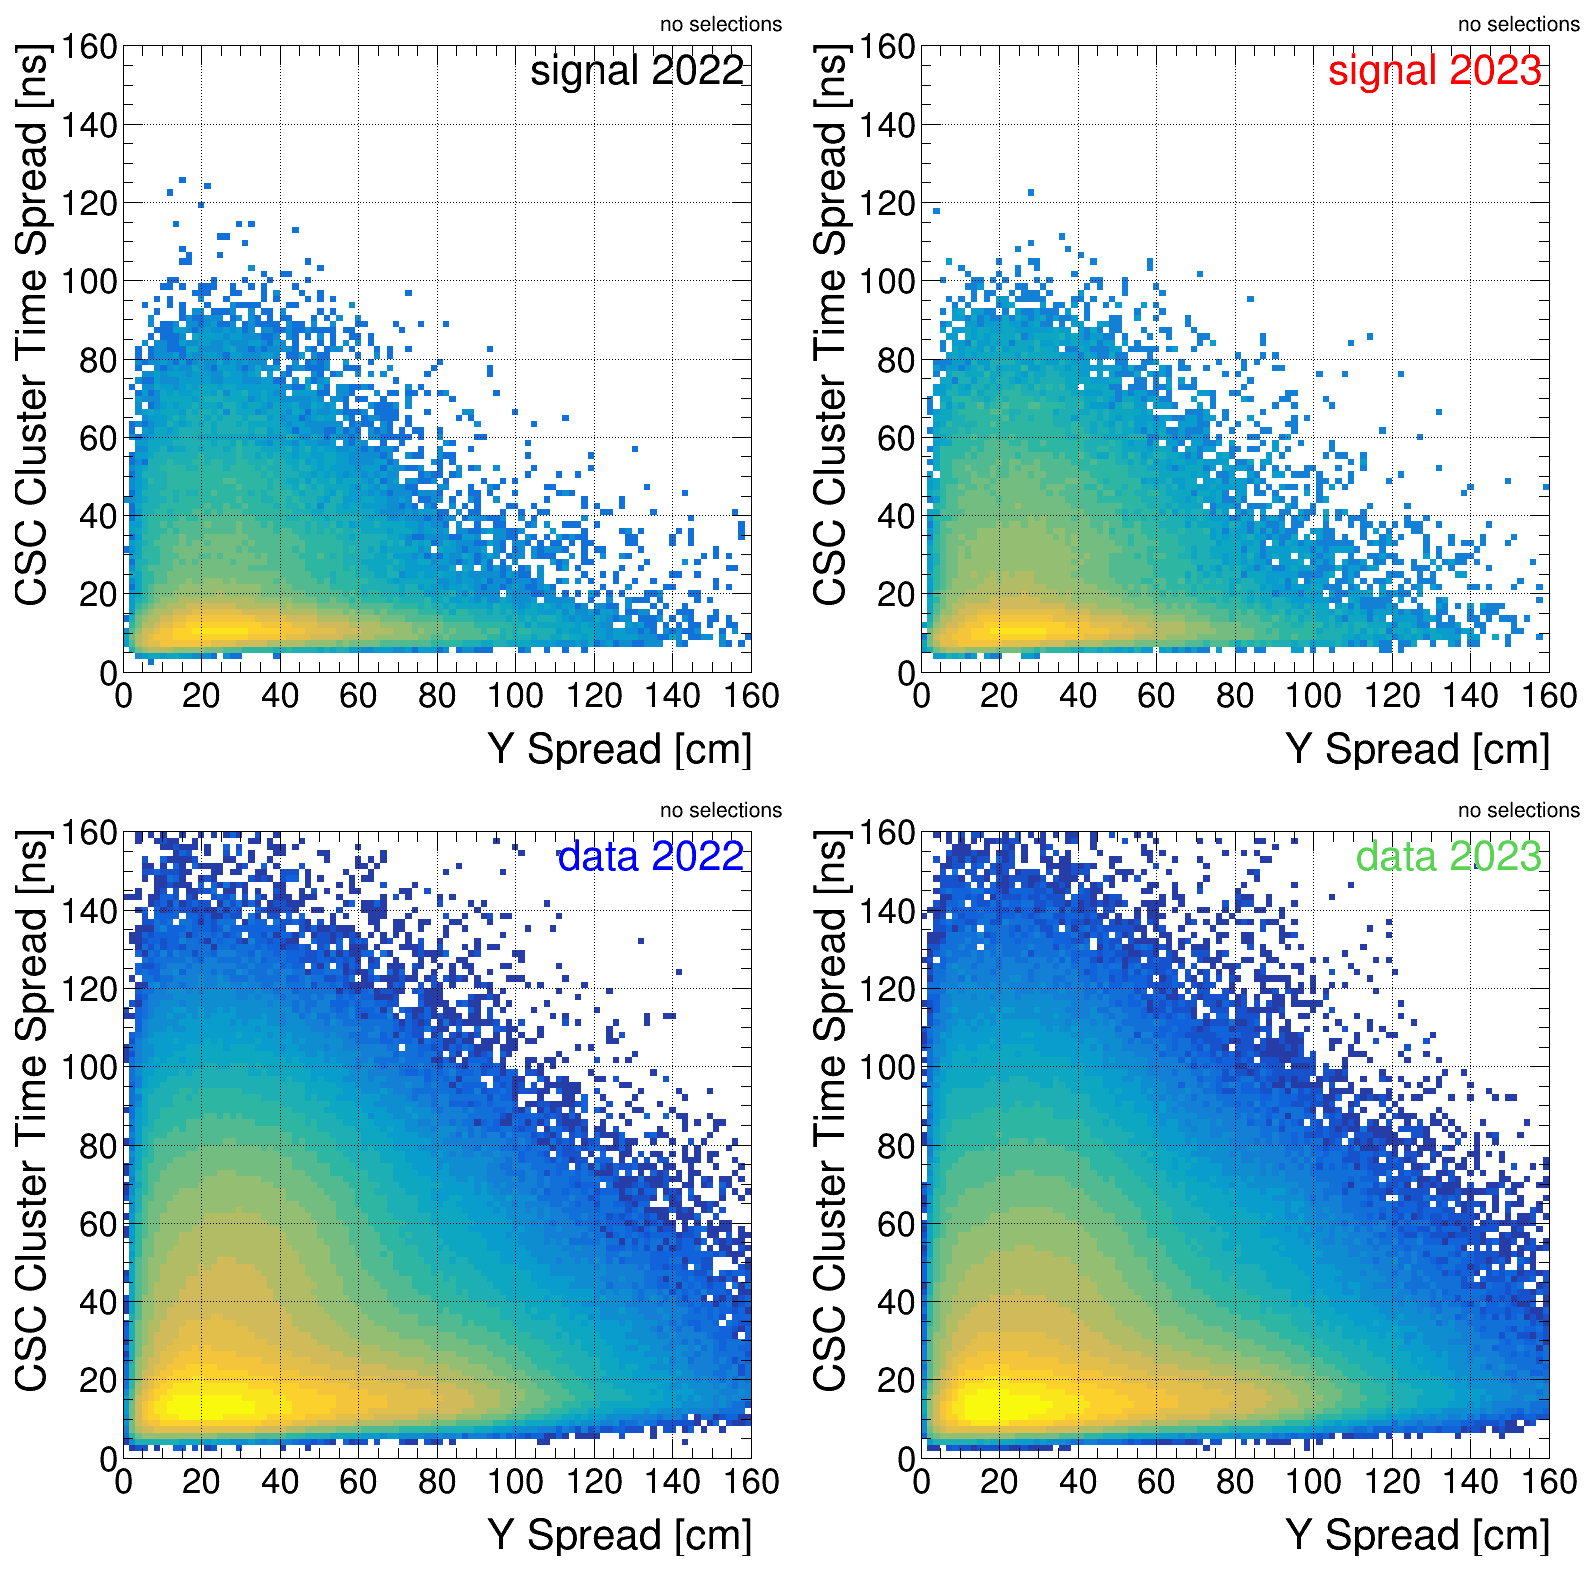

In [154]:
evt_sel = ""
# evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}YSpread", f"met"
form = ("", ";Y Spread [cm];Missing E_{T} [GeV];fraction of events", 50, 0, 100, 50, 0, 200)
logx, logy, logz = False, False, True

xvar, yvar = f"met", f"{C}TimeSpreadWeightedAll"
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 200)
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 100)
logx, logy, logz = False, False, True

xvar, yvar = f"{C}YSpread", f"{C}TimeSpreadWeightedAll"
form = ("", ";Y Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 100, 50, 0, 200)
form = ("", ";Y Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 160, 100, 0, 160)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


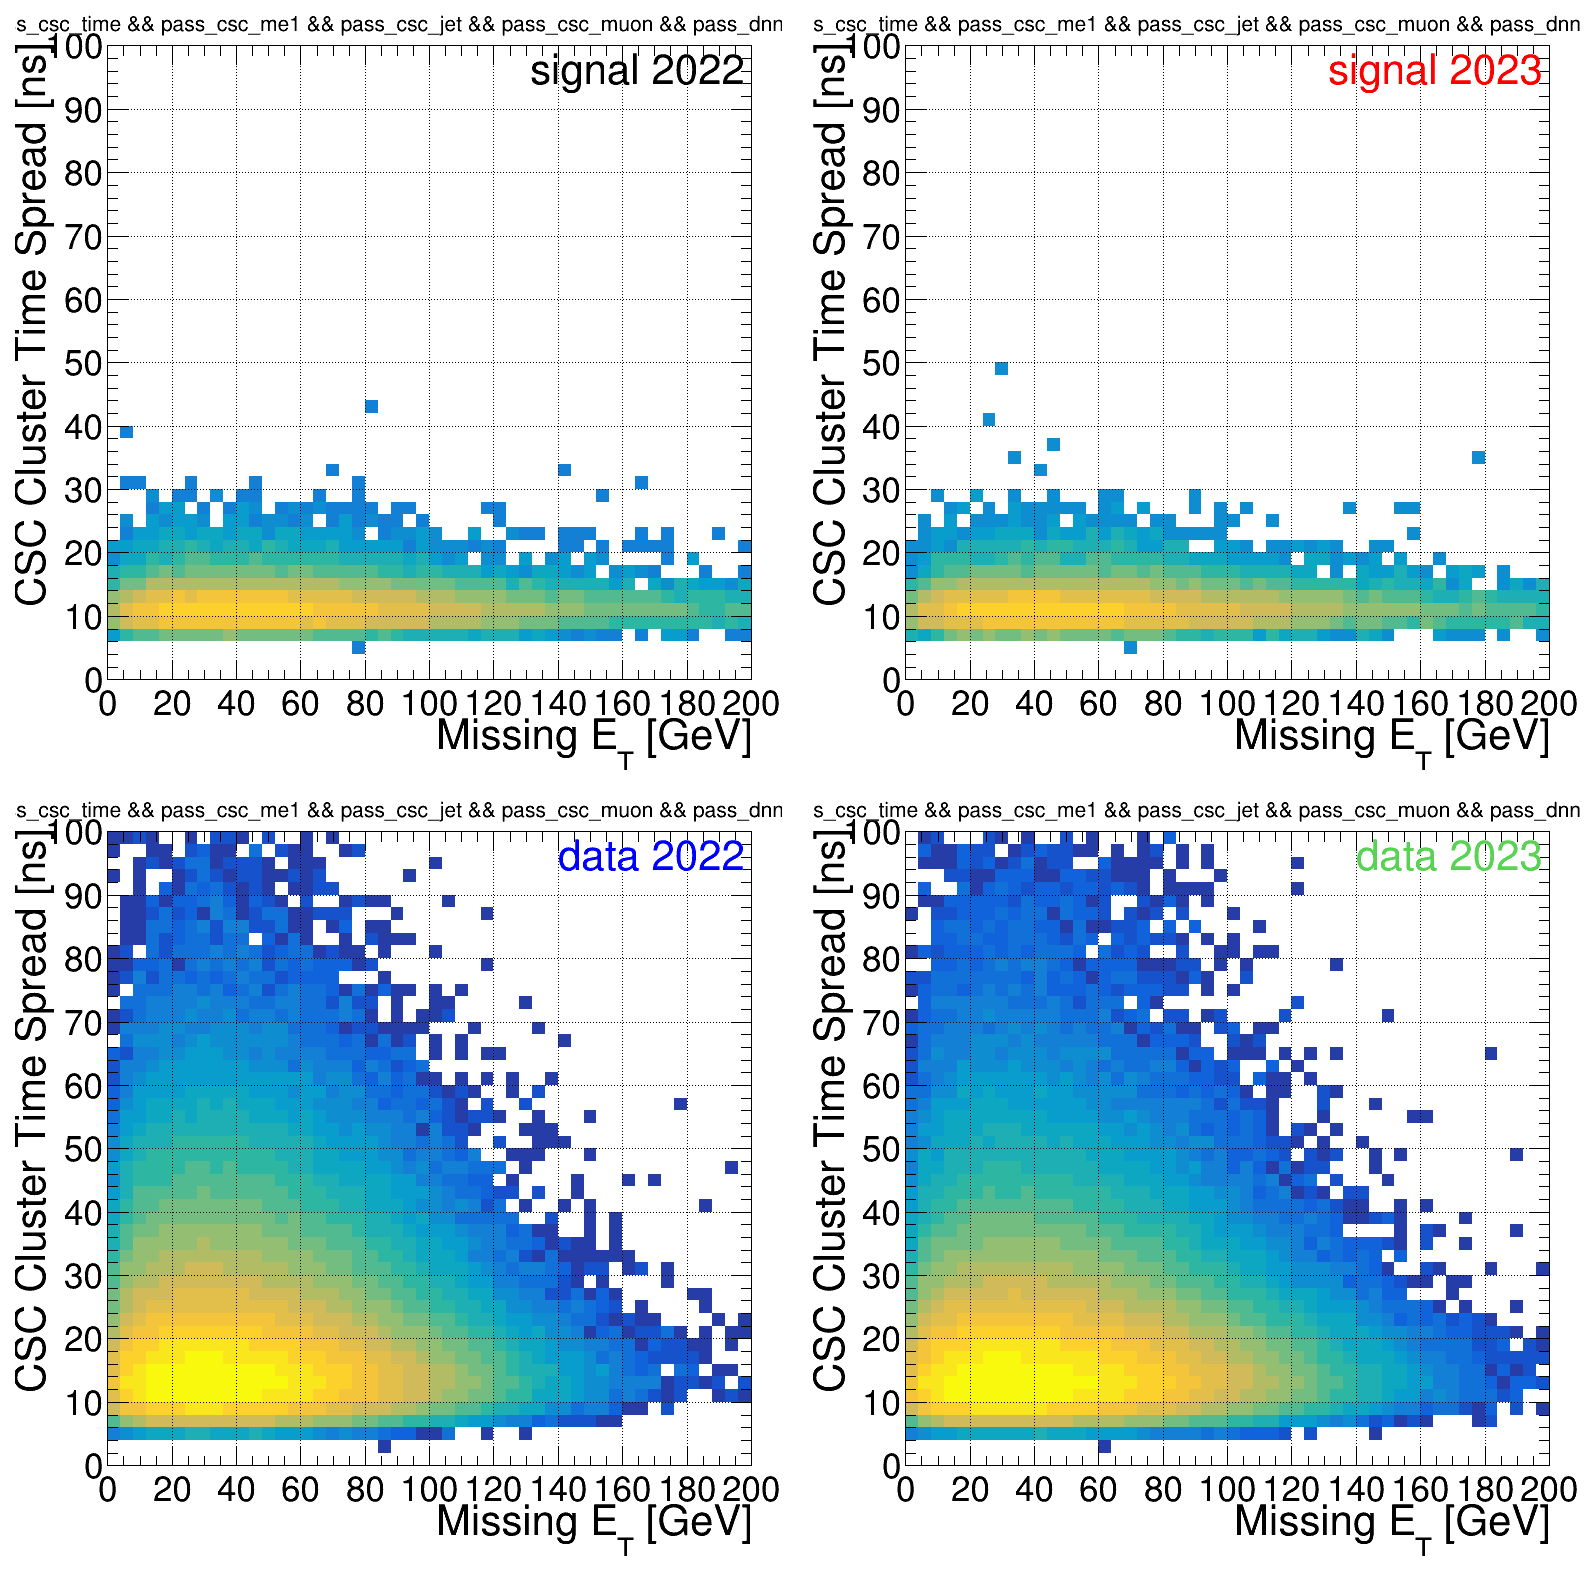

In [73]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_time"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}XYSpread", f"met"
form = ("", ";XY Spread [cm];Missing E_{T} [GeV];fraction of events", 50, 0, 100, 50, 0, 200)
logx, logy, logz = False, False, True

xvar, yvar = f"met", f"{C}TimeSpreadWeightedAll"
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 200)
form = ("", ";Missing E_{T} [GeV];CSC Cluster Time Spread [ns];fraction of events", 50, 0, 200, 50, 0, 100)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


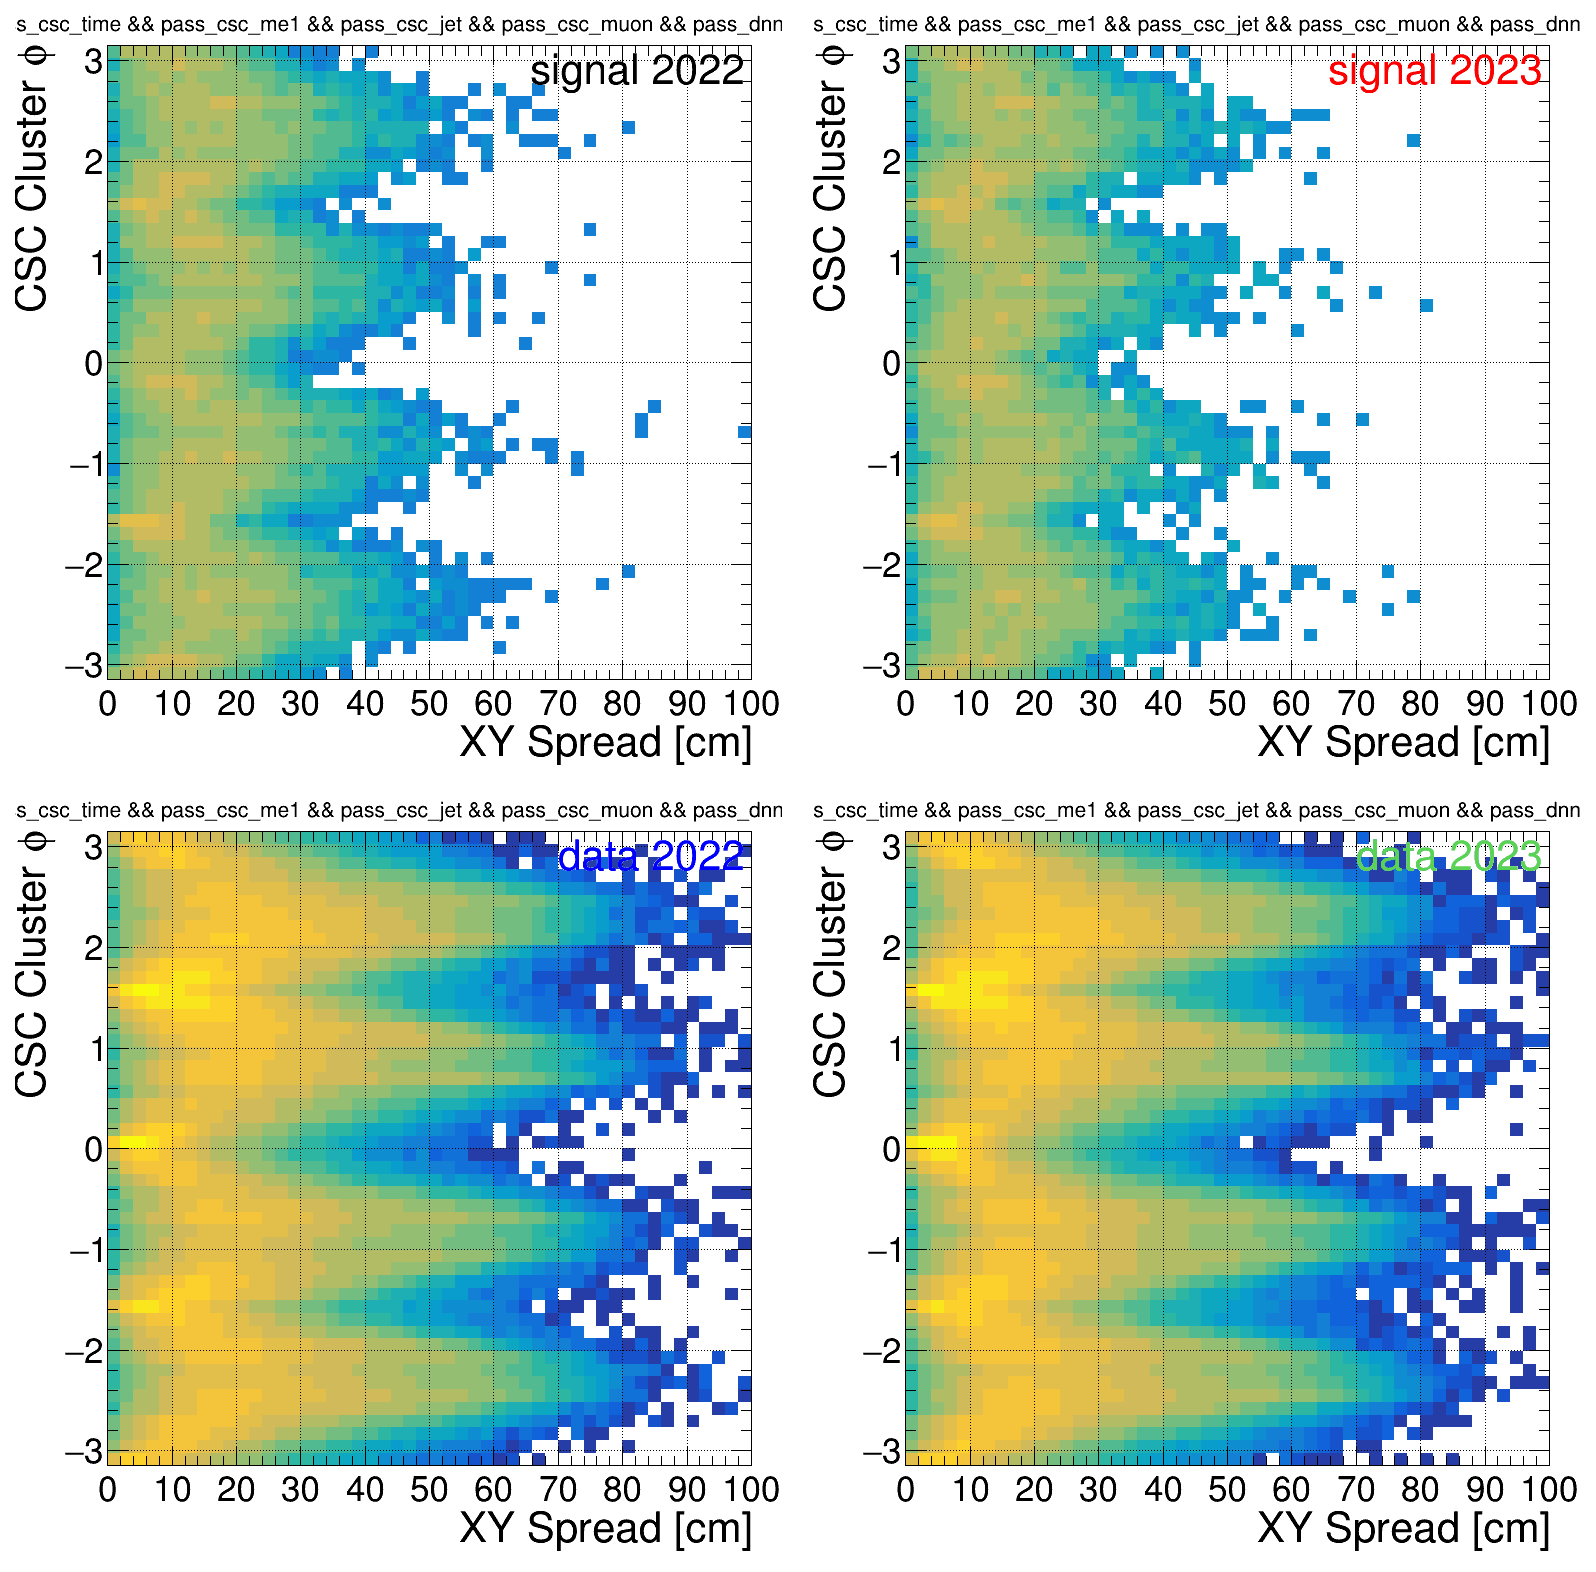

In [76]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_time"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}XYSpread", f"{C}Phi"
form = ("", ";XY Spread [cm];CSC Cluster #phi;fraction of events", 50, 0, 100, 50, -3.15, 3.15)
logx, logy, logz = False, False, True

# xvar, yvar = f"{C}Phi", f"{C}TimeSpreadWeightedAll"
# form = ("", ";CSC Cluster #phi;CSC Cluster Time Spread [ns];fraction of events", 50, -3.15, 3.15, 50, 0, 200)
# form = ("", ";CSC Cluster #phi;CSC Cluster Time Spread [ns];fraction of events", 50, -3.15, 3.15, 50, 0, 100)
# logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


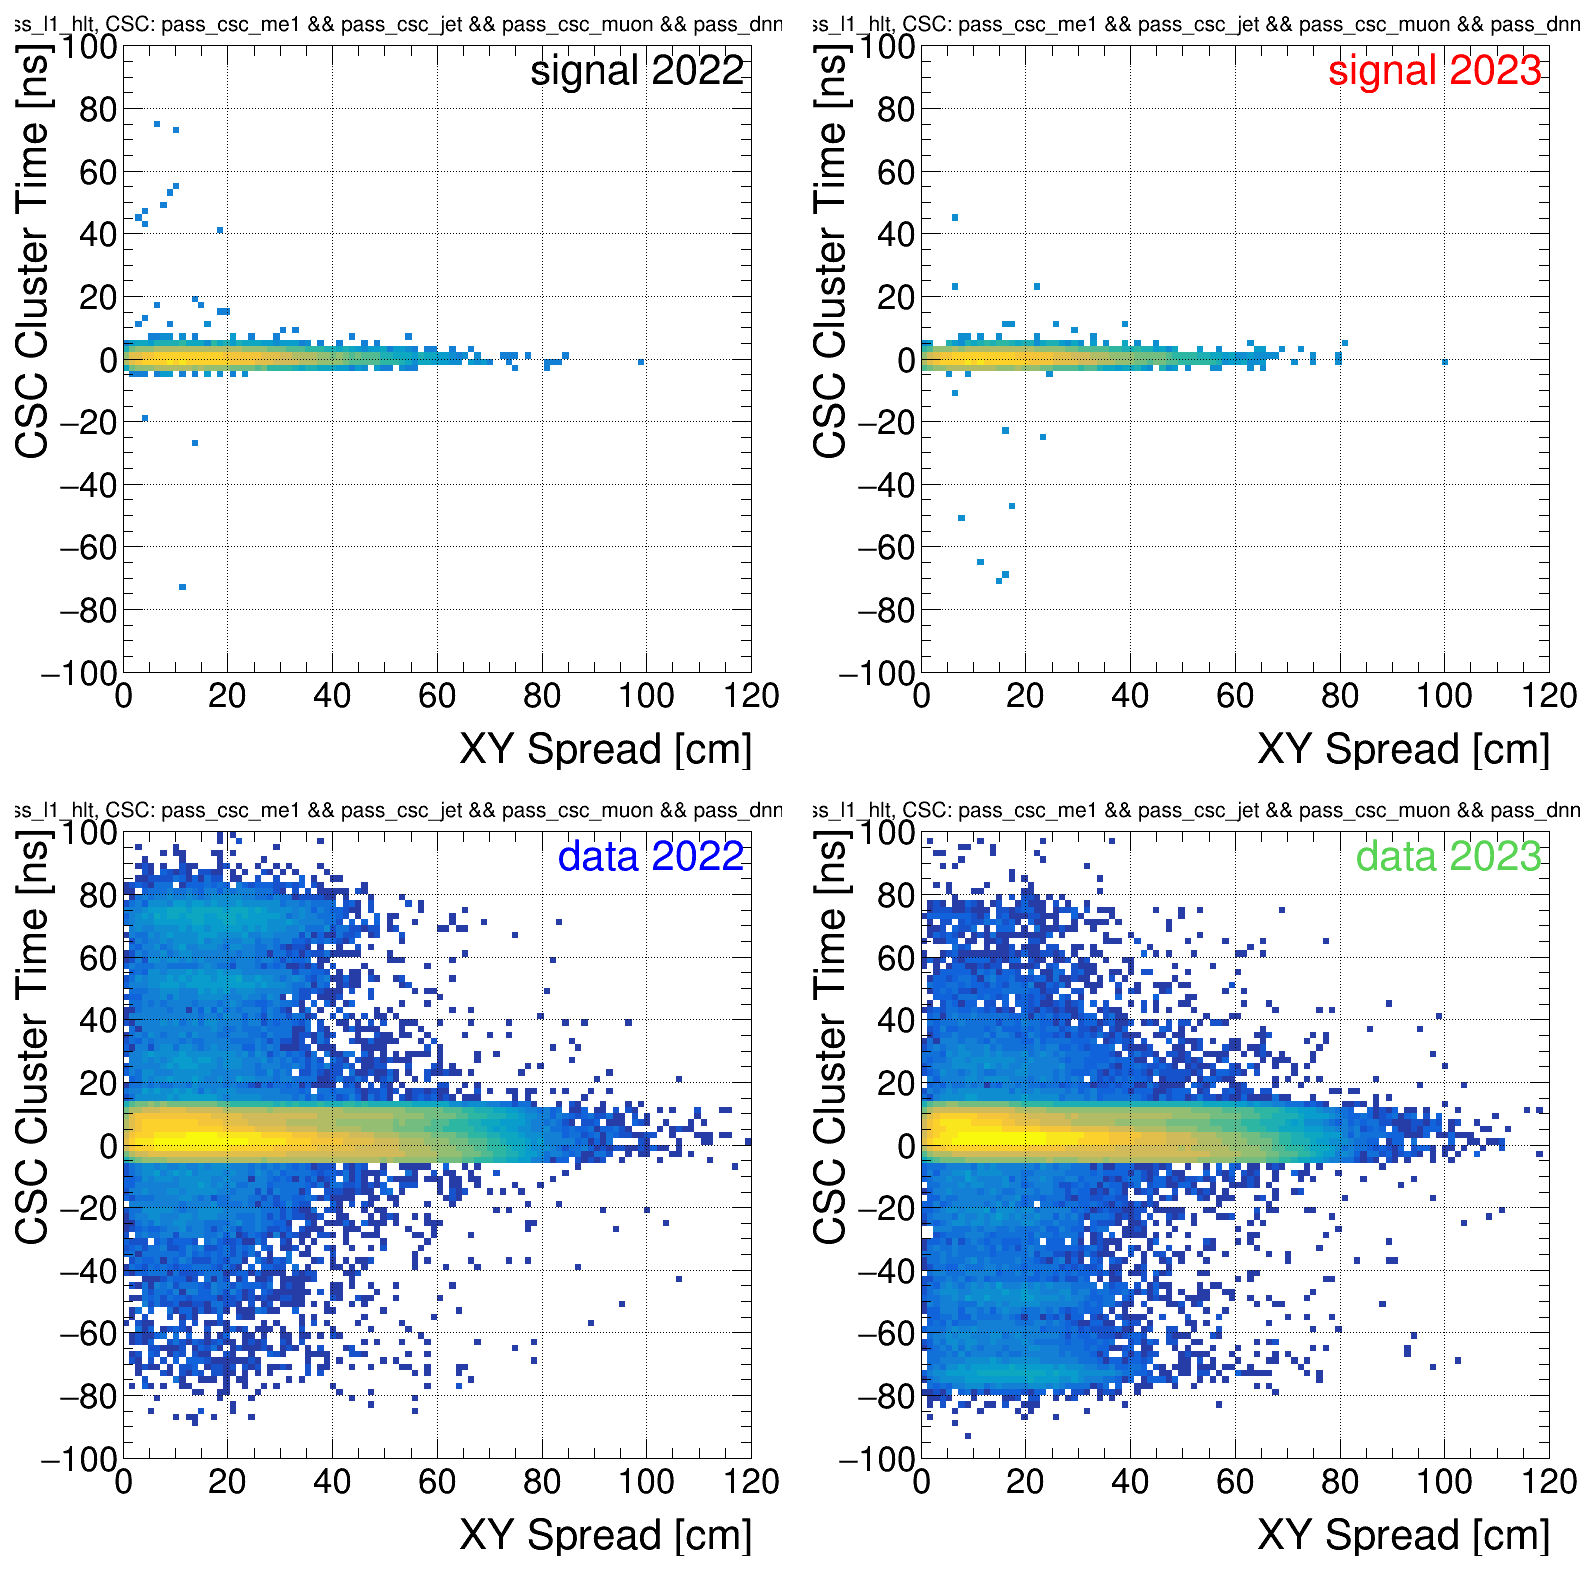

In [187]:
evt_sel = ""
evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"
dt_sel, csc_sel = "", "pass_csc_me1"
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet"
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"


####
xvar, yvar = f"{C}XYSpread", f"{C}TimeWeighted"
form = ("", ";XY Spread [cm];CSC Cluster Time [ns];fraction of events", 50, 0, 100, 50, -20, 20)
form = ("", ";XY Spread [cm];CSC Cluster Time [ns];fraction of events", 100, 0, 120, 100, -20, 20)
form = ("", ";XY Spread [cm];CSC Cluster Time [ns];fraction of events", 100, 0, 120, 100, -100, 100)
# form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 120, 100, 0, 20)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


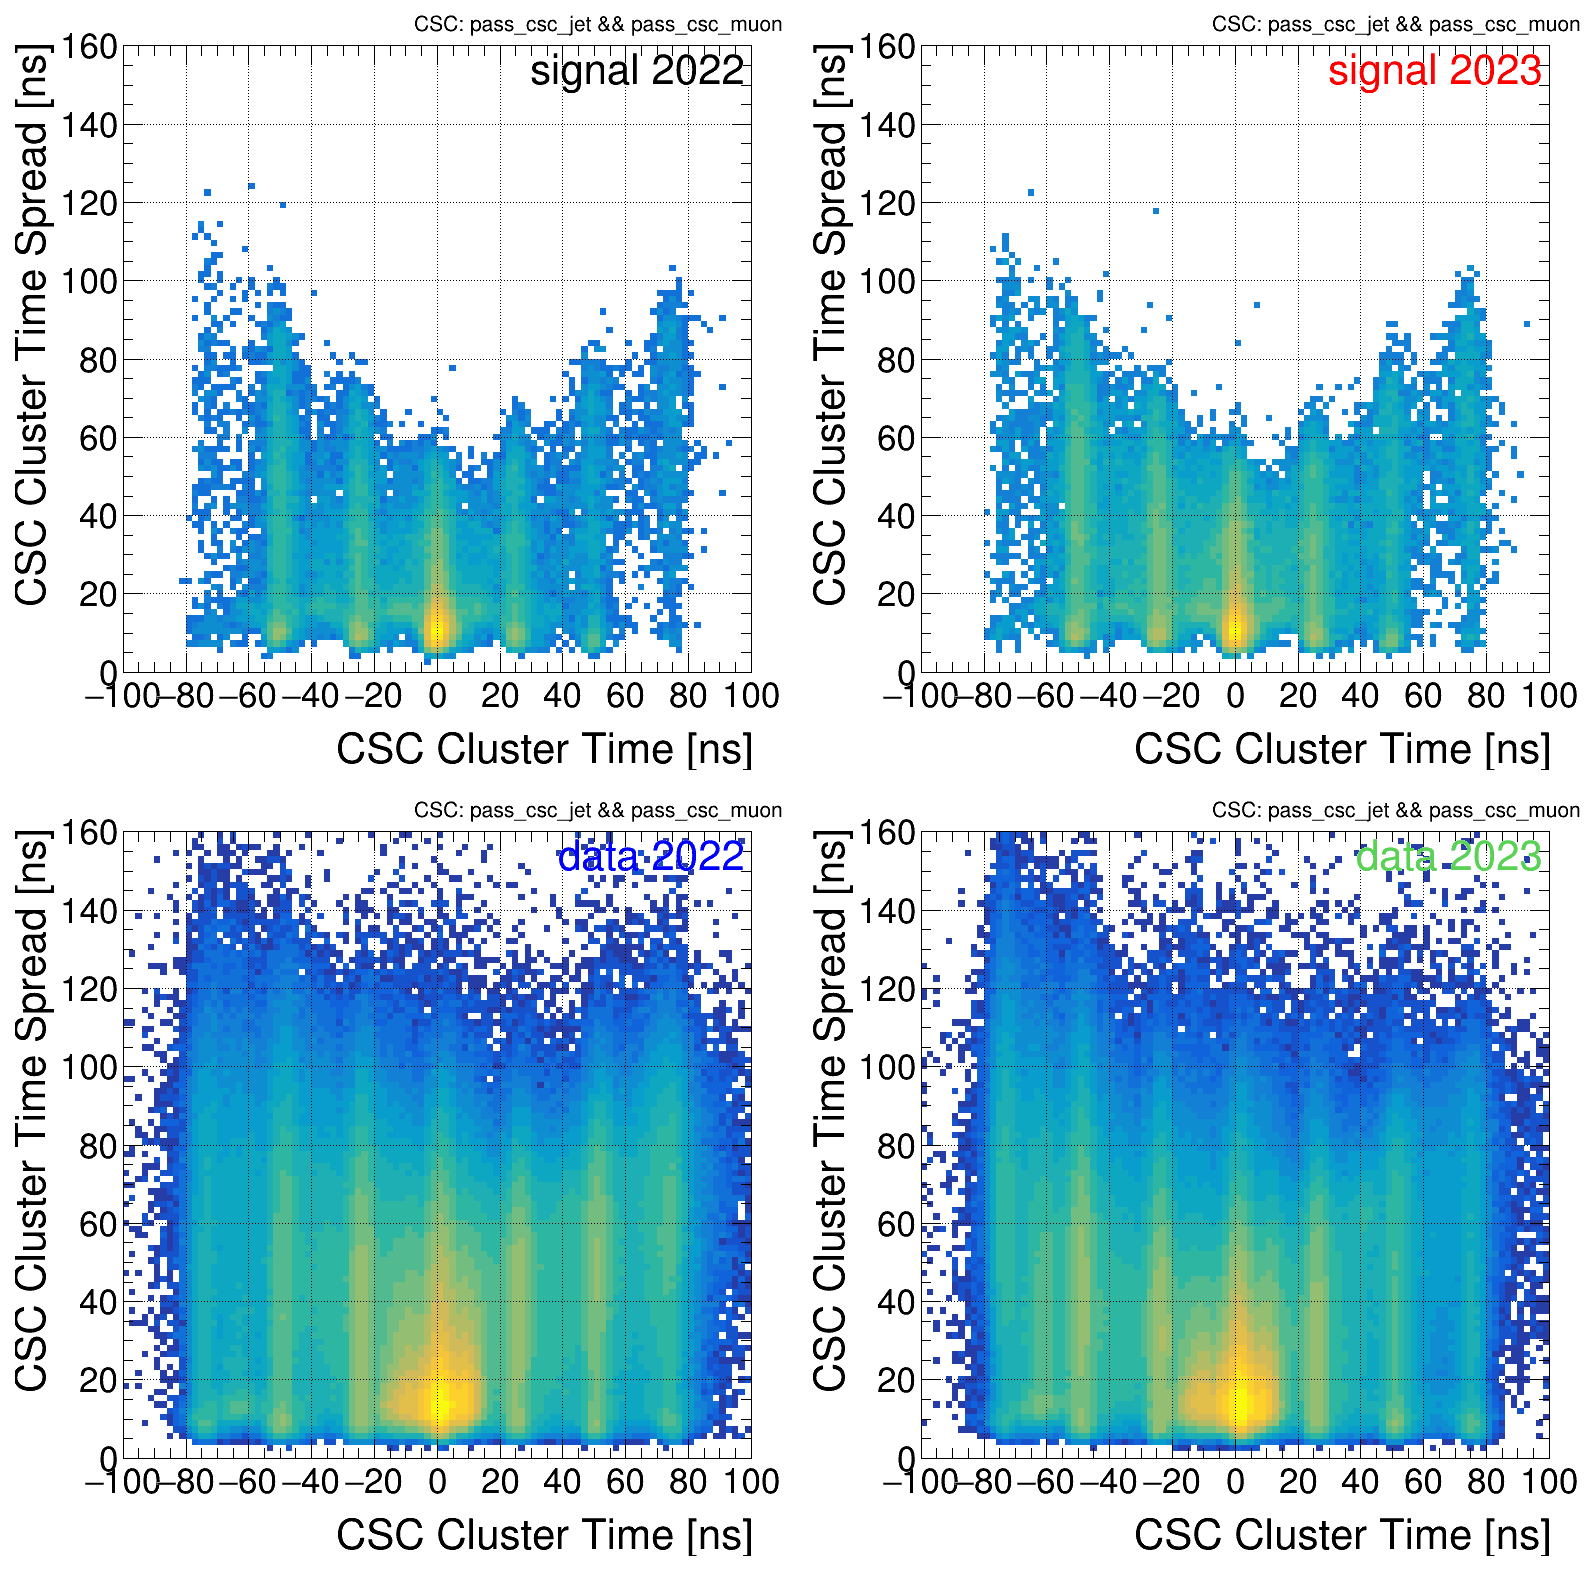

In [215]:
evt_sel = ""
# evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_l1_pl"
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_muon"
# dt_sel, csc_sel = "", "pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
dt_sel, csc_sel = "", "pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"

####
xvar, yvar = f"{C}TimeWeighted", f"{C}TimeSpreadWeightedAll"
form = ("", ";CSC Cluster Time [ns];CSC Cluster Time Spread [ns];fraction of events", 100, -100, 100, 50, 0, 200)
form = ("", ";CSC Cluster Time [ns];CSC Cluster Time Spread [ns];fraction of events", 100, -100, 100, 100, 0, 160)
# form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 120, 100, 0, 20)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)

len(rdfs)=4 =? nrows=2 * ncols=2


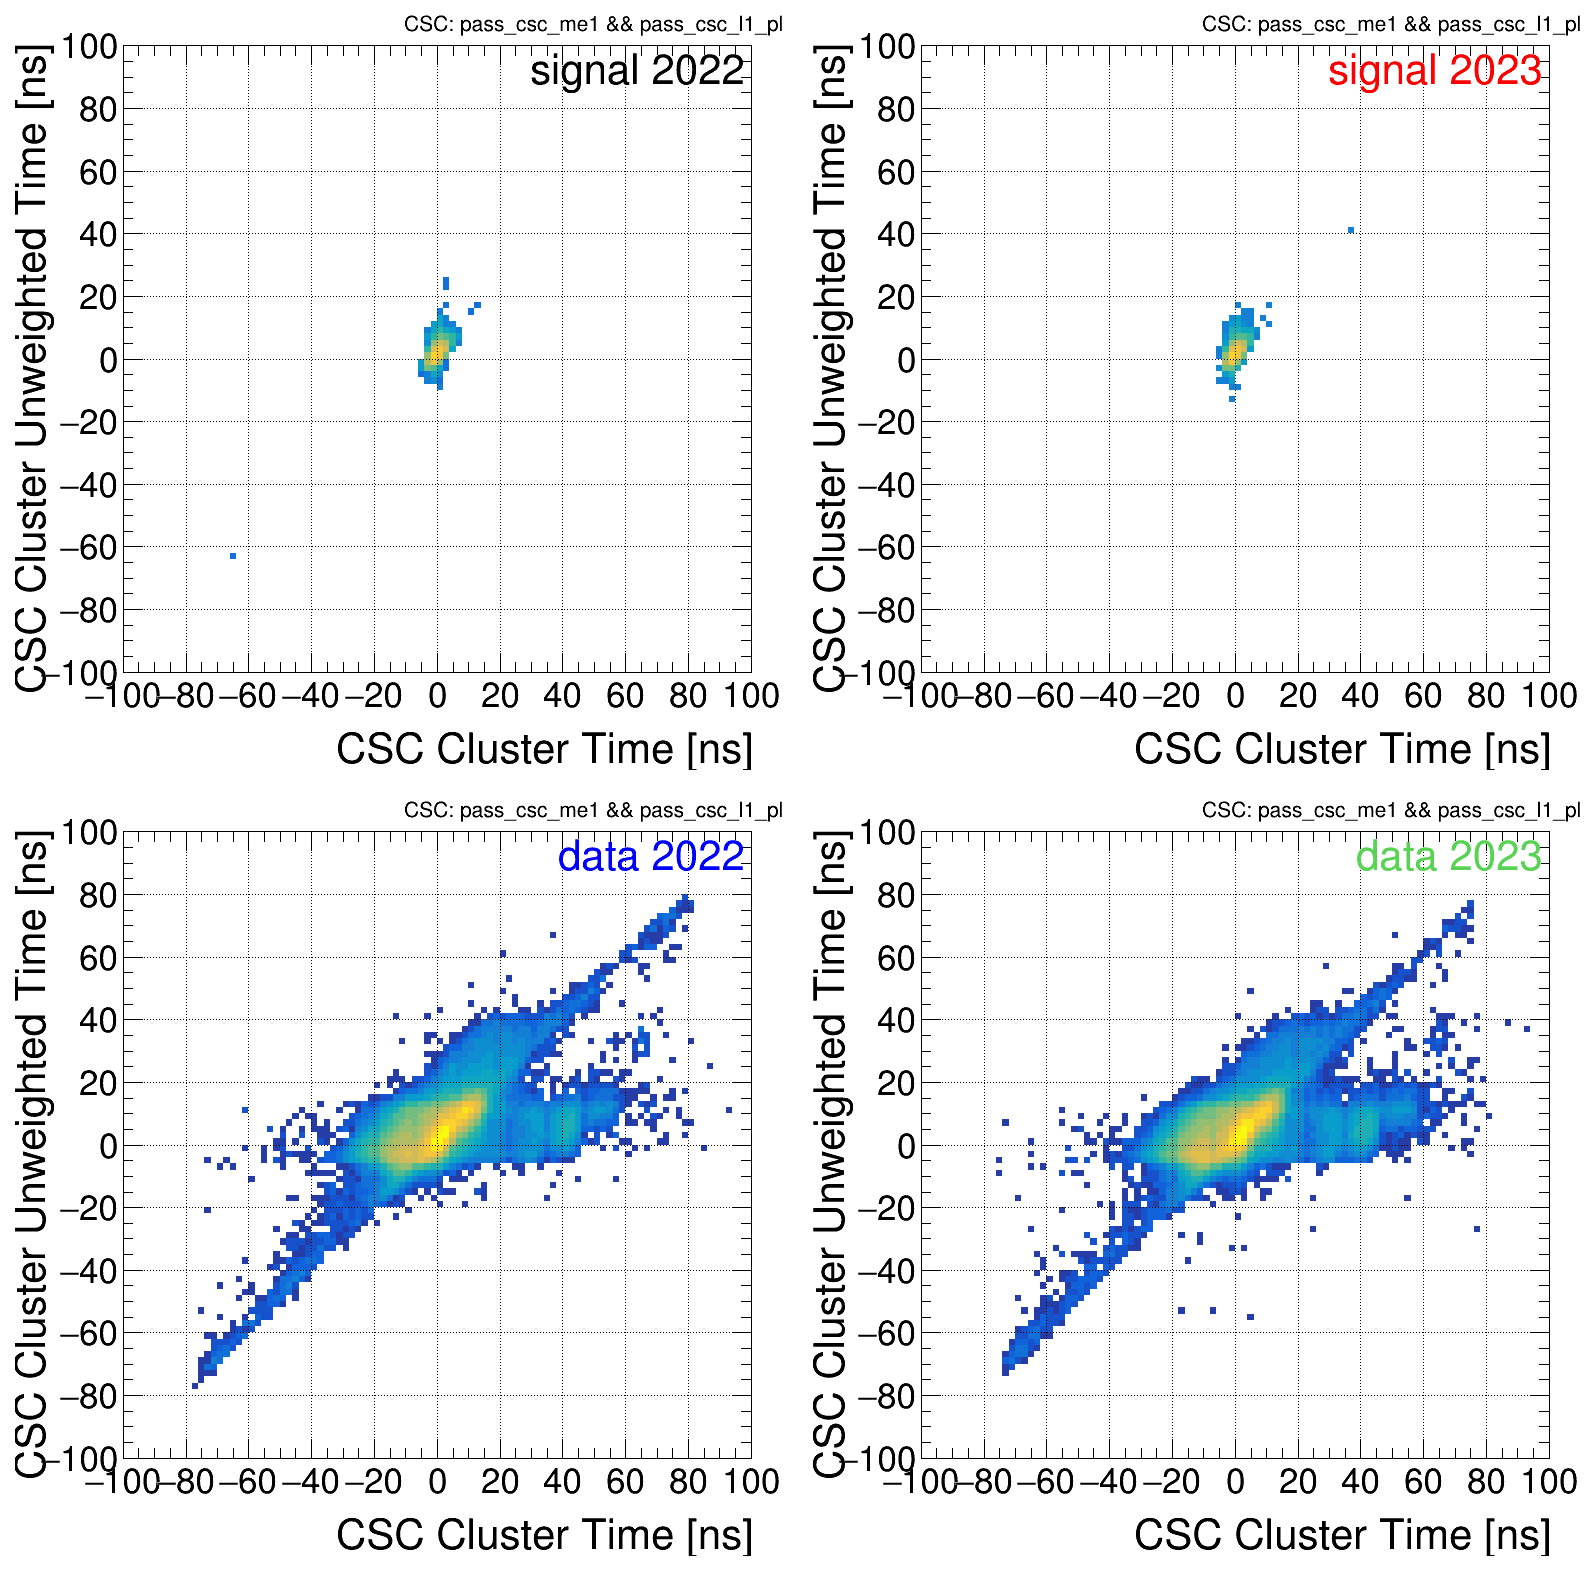

In [226]:
evt_sel = ""
# evt_sel = "pass_l1_hlt"

dt_sel, csc_sel = "", ""
dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_l1_pl"
# dt_sel, csc_sel = "", "pass_csc_time"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_time && pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_me1"
# dt_sel, csc_sel = "", "pass_csc_jet"
# dt_sel, csc_sel = "", "pass_csc_muon"
# dt_sel, csc_sel = "", "pass_dnn"
# dt_sel, csc_sel = "", "pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_jet && pass_csc_muon"
# dt_sel, csc_sel = "", "pass_csc_me1 && pass_csc_jet && pass_csc_muon && pass_dnn"

####
xvar, yvar = f"{C}TimeWeighted", f"{C}Time"
form = ("", ";CSC Cluster Time [ns];CSC Cluster Unweighted Time [ns];fraction of events", 100, -100, 100, 100, -100, 100)
# form = ("", ";XY Spread [cm];CSC Cluster Time Spread [ns];fraction of events", 100, 0, 120, 100, 0, 20)
logx, logy, logz = False, False, True

hists = histo2D(xvar, yvar, form, evt_sel, csc_sel, dt_sel, logx, logy, logz)